<a href="https://colab.research.google.com/github/andreacangiani/NMPDE2025/blob/main/python/C5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Element Method in 1D

1. Linear ($k=1$) Finite Element Method solver for the 1D Poisson problem:

$-u''=f \quad \in \Omega=(a,b)^2$

$u(a)=0=u(b)$

Import usual modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import eigsh

FEM system assembly with trapezoidal rule for rhs

In [3]:
def FEM1_1D_TRAP(omega,N,rhs):
  # 1D FEM with k=1 system matrix and rhs for
  # diffusion problem with homogeneous Dirichlet bc
  # trapezoidal rule uniform grid

  # grid is defined here as uniform
  h = (omega[1]-omega[0]) / N
  x = np.linspace(omega[0],omega[1],N+1)

  # initialise system
  A = sp.lil_matrix((N+1,N+1))
  F = np.zeros(N+1)

  # Assembly loop
  for i in range(N):
    # local contributions
    A_ele = np.matrix([[1/h, -1/h],[-1/h, 1/h]])
    F_ele = 0.5 * h * rhs(x[i:i+2])
    # Assembly local-to-global
    A[i:i+2,i:i+2] += A_ele
    F[i:i+2] += F_ele

  # Apply boundary conditions
  A[0,0] = 1/h; A[0,1] = 0; F[0] = 0
  A[N,N] = 1/h; A[N,N-1] = 0; F[N] = 0

  # return system matrix and rhs vector
  return A, F

Define FEM problem and solve

8.225076221068939e-05


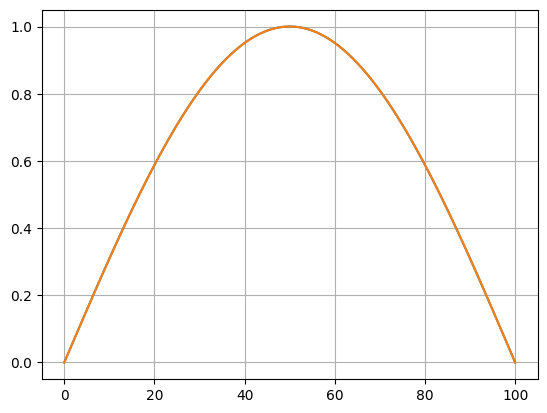

In [4]:
# problem's data
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

# number of subdivisions
N=100

# call function computing FEM system
A, F = FEM1_1D_TRAP(omega,N,rhs)

# solve
A = A.tocsr()
Uh = sp.linalg.spsolve(A,F)

# Evaluate exact solution at grid nodes
x = np.linspace(omega[0],omega[1],N+1)
U = exact(x)

# Plot solutions
plt.plot(Uh)
plt.plot(U)
plt.grid()

# compute discrete max norm error
print(max(abs(U-Uh)))

2. Repeat exercise but for the non-homogeneous Dirichlet conditions, so:

$-u''=f \quad \in \Omega=(a,b)^2$

$u(a)=g(a)$ and $u(b)=g(b)$

for $g$ a given function.

Also:
- allow for nonuniform grid
- use reference element to assemble
- to compute the rhs, use arbitrary order Gauss integration

In [5]:
# Gauss quadrature formula on [0,1]
def quadrature(n_quadrature_points):

  # exploit numpy Gauss quadrature. This is defined in [-1,1]
  q, w = np.polynomial.legendre.leggauss(n_quadrature_points)

  return (q+1)/2, w/2

Function defining the mesh

In [6]:
def mesh(omega,N):
  return np.linspace(omega[0],omega[1],N+1)

Define reference element transformation of coordinates

In [7]:
# Transformation of coordinates functions:
# reference element -> current element
# [0,1] -> [q[i], q[i+1]]

def mapping(q, i):
    # check index is within range
    assert i < len(q)-1
    assert i >= 0
    return lambda x: q[i] + (q[i+1]-q[i]) * x


def mapping_J(q,i):
    assert i < len(q)-1
    assert i >= 0
    return q[i+1]-q[i]


# Linear lagrange basis on reference element
def basis1(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      phi = lambda x: 1-x
    else:
      phi = lambda x: x
    return phi


# Linear lagrange basis derivatives on reference element
def basis1_derivative(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      dphi = lambda x: -np.ones(len(x))
    else:
      dphi = lambda x: np.ones(len(x))
    return dphi



FEM system assembly with Gauss integration



In [8]:
def FEM1_1D_GAUSS(omega,N,n_qpoints,rhs):
  # 1D FEM with k=1 system matrix and rhs
  # not accounting for boundary conditions

  # grid
  vertices = mesh(omega,N)

  # quadrature formula on reference element
  q, w = quadrature(n_qpoints)

  # Evaluation of the two local linear Lagrange basis
  phi = np.array([basis1(i)(q) for i in range(2)]).T
  dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T

  # initialise system
  A = sp.lil_matrix((N+1, N+1))
  F = np.zeros(N+1)

  # Assembly loop
  for i in range(N):
    JxW = mapping_J(vertices,i) * w
    A_ele = np.einsum('qi,qj,q',dphi,dphi,JxW) / mapping_J(vertices,i)**2
    F_ele = np.einsum('qi,q,q',phi,rhs(mapping(vertices,i)(q)),JxW)

    A[i:i+2,i:i+2] += A_ele
    F[i:i+2] += F_ele


  # return system matrix and rhs vector
  return A, F

Function implementing the boundary (nonhomogeneous) Dirichlet conditions. (Similar to FD code, but boundary condition given by sunction $g$!)

In [9]:
def apply_boundary_conditions(omega, N, A, F, g):
    # zero row 0 and set diagonal
    A[0,:] = 0
    A[0,0] = 1
    F[0] = g(omega[0])

    # zero row N and set diagonal
    A[N,:] = 0
    A[N,N] = 1
    F[N] = g(omega[1])


Define FEM problem and solve

0.011700512265437224


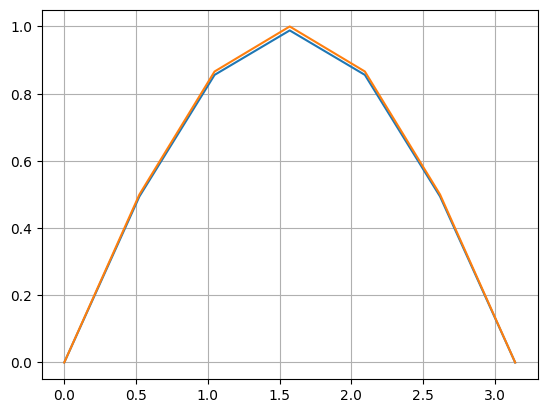

In [10]:
# problem's data
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

# number of subdivisions
N=6

n_qpoints = 1

# call function computing FEM system
A, F = FEM1_1D_GAUSS(omega,N,n_qpoints,rhs)
apply_boundary_conditions(omega,N, A, F, exact)

# solve
A = A.tocsr()
Uh = sp.linalg.spsolve(A,F)

# Evaluate exact solution at grid nodes
x = np.linspace(omega[0],omega[1],N+1)
U = exact(x)

# Plot solutions
plt.plot(x,Uh)
plt.plot(x,U)
plt.grid()


# compute discrete max norm error
print(max(abs(U-Uh)))


Next we run few experiment to confirm the theoretical convergence and growth of the condition number.

In [11]:
# problem's data
omega = [0,1]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

# number of experiment
no_experiments = 10
# Initialise error vector
Err = np.zeros(no_experiments)
NN = np.zeros(no_experiments)
Cond = np.zeros(no_experiments)

n_qpoints = 1



# experiments loop
for i in range(no_experiments):
  # double number of partitions
  N = 2**(i+2)
  NN[i] = N

  # call function computing FEM system
  A, F = FEM1_1D_GAUSS(omega,N,n_qpoints,rhs)
  apply_boundary_conditions(omega,N, A, F, exact)

  # solve
  Uh = sp.linalg.spsolve(A,F)
  # condition number of Stiffness matrix
  Cond[i] = np.linalg.cond(A.todense(),p=2)

  # Evaluate exact solution at grid nodes
  vertices = mesh(omega,N)
  U =exact(vertices)

  # Compute errors
  Err[i] = max(abs(U-Uh))
  print(Err[i])





0.000153676798680058
3.8579993686838066e-05
9.764932852762698e-06
2.4406074892180385e-06
6.101529381741244e-07
1.525726593953891e-07


C:\Users\Giacomo\AppData\Local\Temp\ipykernel_12536\3022764183.py:28: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  Uh = sp.linalg.spsolve(A,F)


3.814299143201083e-08
9.535742750976794e-09
2.3838447882340574e-09
5.960996141141095e-10


[   4.    8.   16.   32.   64.  128.  256.  512. 1024. 2048.]


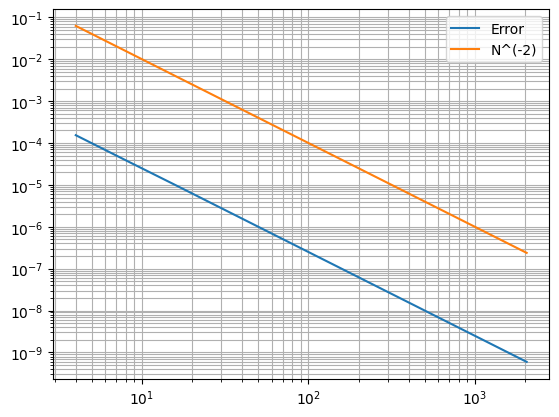

In [12]:
# Plot error
print(NN)
plt.loglog(NN,Err,label="Error")
plt.loglog(NN,NN**(-2),label="N^(-2)")
plt.legend()
plt.grid(True, which='both')


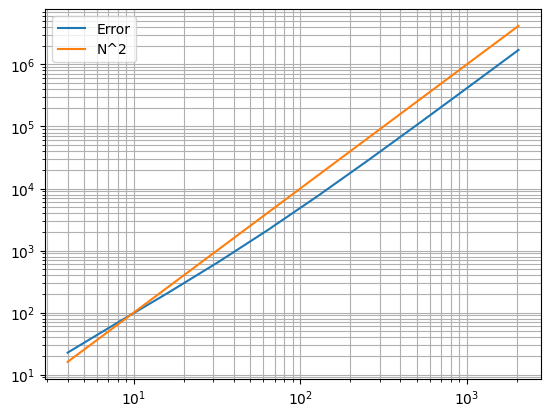

In [13]:
plt.loglog(NN,Cond,label="Error")
plt.loglog(NN,NN**2,label="N^2")
plt.legend()
plt.grid(True, which='both')


**Exercise 1** Write a function computing $H^1$-norm error

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

# -------------------------
# H1 seminorm error function
# -------------------------
def H1_error(vertices, Uh, exact_derivative):
    """
    Simple H1 seminorm FEM error for linear elements.
    Uses midpoint evaluation on each element.
    """
    N = len(vertices) - 1
    assert len(vertices) == len(Uh), "Mismatch between mesh and solution vector!"

    error_sq = 0.0
    for i in range(N):
        xL, xR = vertices[i], vertices[i+1]
        h = xR - xL

        xm = 0.5*(xL + xR)
        du_exact = exact_derivative(xm)
        du_h = (Uh[i+1] - Uh[i]) / h

        error_sq += h * (du_exact - du_h)**2

    return np.sqrt(error_sq)

# -------------------------
# Optional: L2 error
# -------------------------
def L2_error(vertices, Uh, exact):
    """
    Simple L2 norm FEM error for linear elements.
    Midpoint rule per element.
    """
    N = len(vertices) - 1
    error_sq = 0.0
    for i in range(N):
        xL, xR = vertices[i], vertices[i+1]
        h = xR - xL
        xm = 0.5*(xL + xR)
        error_sq += h * (exact(xm) - 0.5*(Uh[i]+Uh[i+1]))**2
    return np.sqrt(error_sq)

and test convergence this time for $\| u - u_h \|_{H^1(a,b)}$.

C:\Users\Giacomo\AppData\Local\Temp\ipykernel_12536\2081373792.py:21: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  Uh = sp.linalg.spsolve(A,F)


N=4, H1 error=2.2228e-03, L2 error=4.0564e-03
N=8, H1 error=5.5535e-04, L2 error=1.0184e-03
N=16, H1 error=1.3881e-04, L2 error=2.5488e-04
N=32, H1 error=3.4702e-05, L2 error=6.3737e-05
N=64, H1 error=8.6755e-06, L2 error=1.5935e-05
N=128, H1 error=2.1689e-06, L2 error=3.9839e-06
N=256, H1 error=5.4222e-07, L2 error=9.9598e-07


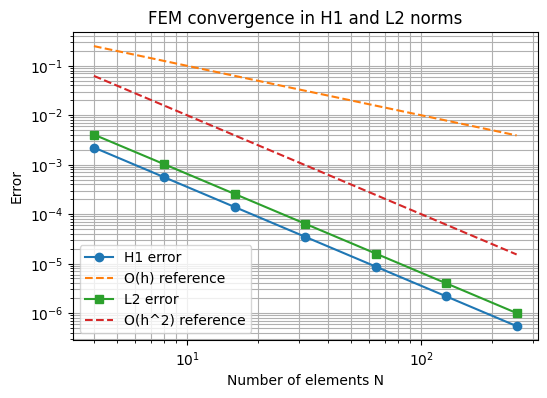

In [15]:
omega = [0,1]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)
exact_derivative = lambda x: np.cos(x)
no_experiments = 7
n_qpoints = 5

ErrH1 = np.zeros(no_experiments)
ErrL2 = np.zeros(no_experiments)
NN = np.zeros(no_experiments)

for i in range(no_experiments):
    N = 2**(i+2)
    NN[i] = N

    # Assemble FEM system (using your Gauss-based function)
    A, F = FEM1_1D_GAUSS(omega,N,n_qpoints,rhs)
    apply_boundary_conditions(omega,N, A, F, exact)

    # Solve
    Uh = sp.linalg.spsolve(A,F)

    # Mesh
    vertices = mesh(omega,N)

    # Compute errors
    ErrH1[i] = H1_error(vertices, Uh, exact_derivative)
    ErrL2[i] = L2_error(vertices, Uh, exact)

    print(f"N={N}, H1 error={ErrH1[i]:.4e}, L2 error={ErrL2[i]:.4e}")

plt.figure(figsize=(6,4))
plt.loglog(NN, ErrH1, 'o-', label='H1 error')
plt.loglog(NN, NN**-1, '--', label='O(h) reference')
plt.loglog(NN, ErrL2, 's-', label='L2 error')
plt.loglog(NN, NN**-2, '--', label='O(h^2) reference')
plt.xlabel('Number of elements N')
plt.ylabel('Error')
plt.title('FEM convergence in H1 and L2 norms')
plt.legend()
plt.grid(True, which='both')
plt.show()


**Exercise 2**: Try same exercise, this time with nonuniform grid

In [48]:
def nonuniform_mesh(omega, N, p=1.5):
    a, b = omega
    i = np.arange(N+1)
    return a + (b-a) * (i/N)**p

def random_mesh(omega, N):
    """
    Generate a random nonuniform mesh in [a,b] with N elements.
    Returns N+1 sorted points.
    """
    a, b = omega
    
    # generate N-1 random interior points in (a,b)
    interior = a + (b-a) * np.random.rand(N-1)
    
    # full mesh: include endpoints
    vertices = np.concatenate(([a], interior, [b]))
    
    # sort to ensure increasing order
    vertices.sort()
    
    return vertices


def FEM1_1D_GAUSS_NON_UNIFORM(vertices, n_qpoints, rhs):
    """
    FEM assembly for linear elements on arbitrary mesh `vertices`.
    Returns A, F (not accounting for BCs).
    """
    N = len(vertices)-1
    q, w = quadrature(n_qpoints)
    
    phi = np.array([basis1(i)(q) for i in range(2)]).T
    dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T
    
    A = sp.lil_matrix((N+1, N+1))
    F = np.zeros(N+1)
    
    for i in range(N):
        J = vertices[i+1]-vertices[i]
        xq = vertices[i] + J*q
        JxW = J*w
        
        A_ele = np.einsum('qi,qj,q', dphi, dphi, JxW) / J**2
        F_ele = np.einsum('qi,q,q', phi, rhs(xq), JxW)
        
        A[i:i+2,i:i+2] += A_ele
        F[i:i+2] += F_ele
        
    return A, F


C:\Users\Giacomo\AppData\Local\Temp\ipykernel_12536\959412533.py:30: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  Uh = sp.linalg.spsolve(A,F)


N=4, H1 error=8.5524e-03, L2 error=7.4775e-03
N=8, H1 error=1.9601e-03, L2 error=3.8780e-03
N=16, H1 error=9.2421e-04, L2 error=2.4899e-03
N=32, H1 error=3.8131e-04, L2 error=3.6125e-04
N=64, H1 error=7.0752e-05, L2 error=1.3022e-04
N=128, H1 error=2.5796e-05, L2 error=7.4767e-05
N=256, H1 error=5.6580e-06, L2 error=1.7041e-05


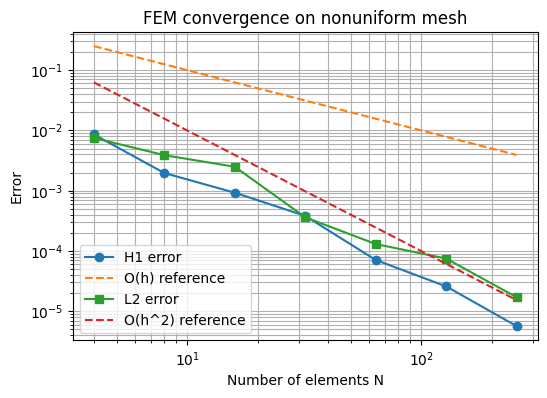

In [58]:

omega = [0,1]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)
exact_derivative = lambda x: np.cos(x)

no_experiments = 7
n_qpoints = 5
ErrH1 = np.zeros(no_experiments)
ErrL2 = np.zeros(no_experiments)
NN = np.zeros(no_experiments)

# -------------------------
# Convergence loop
# -------------------------
for i in range(no_experiments):
    N = 2**(i+2)
    NN[i] = N

    # generate nonuniform mesh
    vertices = nonuniform_mesh(omega, N, p=7)
    vertices = random_mesh(omega, N)
    # vertices = mesh(omega, N)


    # assemble FEM (using your Gauss-based function)
    A, F = FEM1_1D_GAUSS_NON_UNIFORM(vertices,n_qpoints,rhs)
    apply_boundary_conditions(omega,N,A,F,exact)

    # solve
    Uh = sp.linalg.spsolve(A,F)

    # compute errors
    ErrH1[i] = H1_error(vertices, Uh, exact_derivative)
    ErrL2[i] = L2_error(vertices, Uh, exact)

    print(f"N={N}, H1 error={ErrH1[i]:.4e}, L2 error={ErrL2[i]:.4e}")

# -------------------------
# Plot convergence
# -------------------------
plt.figure(figsize=(6,4))
plt.loglog(NN, ErrH1, 'o-', label='H1 error')
plt.loglog(NN, NN**-1, '--', label='O(h) reference')
plt.loglog(NN, ErrL2, 's-', label='L2 error')
plt.loglog(NN, NN**-2, '--', label='O(h^2) reference')
plt.xlabel('Number of elements N')
plt.ylabel('Error')
plt.title('FEM convergence on nonuniform mesh')
plt.legend()
plt.grid(True, which='both')
plt.show()


**Exercise 3**: Write code solving general reaction-advection-diffusion problems

In [59]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

# Linear Lagrange basis on reference element [0,1]
def basis1(i):
    if i == 0: return lambda x: 1-x
    else: return lambda x: x

def basis1_derivative(i):
    if i == 0: return lambda x: -np.ones_like(x)
    else: return lambda x: np.ones_like(x)

# Gauss quadrature on [0,1]
def quadrature(n_qpoints):
    q, w = np.polynomial.legendre.leggauss(n_qpoints)
    return (q+1)/2, w/2

# FEM assembly on general mesh
def FEM1D_RAD(vertices, n_qpoints, rhs, nu=1.0, beta=0.0, sigma=0.0):
    N = len(vertices)-1
    q, w = quadrature(n_qpoints)
    
    phi = np.array([basis1(i)(q) for i in range(2)]).T
    dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T
    
    A = sp.lil_matrix((N+1, N+1))
    F = np.zeros(N+1)
    
    for i in range(N):
        xL, xR = vertices[i], vertices[i+1]
        J = xR - xL
        xq = xL + J*q
        JxW = J*w
        
        # Diffusion term: nu * (u',v')
        A_ele_diff = np.einsum('qi,qj,q', dphi, dphi, JxW) * nu / J**2
        # Advection term: beta * (u',v)
        A_ele_adv  = np.einsum('qi,qj,q', dphi, phi, JxW) * beta / J
        # Reaction term: sigma * (u,v)
        A_ele_reac = np.einsum('qi,qj,q', phi, phi, JxW) * sigma
        
        A_ele = A_ele_diff + A_ele_adv + A_ele_reac
        
        # RHS
        F_ele = np.einsum('qi,q,q', phi, rhs(xq), JxW)
        
        A[i:i+2,i:i+2] += A_ele
        F[i:i+2] += F_ele
        
    return A, F

# Apply Dirichlet BCs
def apply_dirichlet(vertices, A, F, g):
    N = len(vertices)-1
    # left
    A[0,:] = 0
    A[0,0] = 1
    F[0] = g(vertices[0])
    # right
    A[N,:] = 0
    A[N,N] = 1
    F[N] = g(vertices[N])


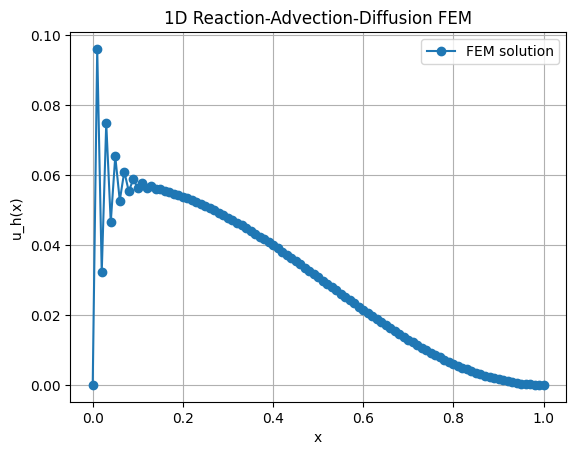

In [96]:
import matplotlib.pyplot as plt

# Mesh
N = 100
omega = [0,1]
vertices = np.linspace(omega[0],omega[1],N+1)

# Problem parameters
nu = 0.01
beta = 10.0
sigma = 2.0
rhs = lambda x: np.sin(np.pi*x)
g = lambda x: 0.0  # Dirichlet BCs

# Assemble FEM
A, F = FEM1D_RAD(vertices, n_qpoints=3, rhs=rhs, nu=nu, beta=beta, sigma=sigma)
apply_dirichlet(vertices, A, F, g)

# Solve
Uh = spsolve(A.tocsr(), F)

# Plot solution
plt.plot(vertices, Uh, '-o', label='FEM solution')
plt.xlabel('x'); plt.ylabel('u_h(x)')
plt.title('1D Reaction-Advection-Diffusion FEM')
plt.grid(True)
plt.legend()
plt.show()
